# Part 1: Lyric Genre Prediction Task - 45% (of project total)


connect to my google drive to get the dataset and anything else needed


In [1]:
from google.colab import drive
drive.mount('/content/drive')
# !mkdir /home/lyrics/
# !cp -v /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/*.csv /home/lyrics/
# !ls -ltrh /home/lyrics/ 
# !cp -v /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/glove.6B.100d.txt /home/lyrics/ 
# !ls -ltrh /home/lyrics/ 

Mounted at /content/drive


In [ ]:
!pip install sklearn-evaluation &>/dev/null

## Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import pickle
import tensorflow_hub as hub

## global parameters

In [3]:
WORKDIR = "/content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/"
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

## create the train set and save the test set for later


In [ ]:
def run_me_once():
  """put away a separate test set so I can try it out on download models in 
  the future. This test set will have the same proportions as the whole 
  dataset in terms of Genres.Test set will be 10% of the dataset"""
  lyrics_df = pd.read_csv(
      os.path.join(WORKDIR, 'train.csv'))
  lyrics_df = lyrics_df.query('Language == "en"') # only concerned with english data

  # Initial train and test split.
  train_df, test_df = train_test_split(
      lyrics_df,
      test_size=0.1,
      stratify=lyrics_df["Genre"].values,
      shuffle=True
  )
  train_df.to_csv(os.path.join(WORKDIR, 'train_df.csv'))
  test_df.to_csv(os.path.join(WORKDIR, 'test_df.csv'))
    

# run_me_once()

function to get the test set


In [4]:
def give_me_the_test_set():
  test_df = pd.read_csv(os.path.join(WORKDIR, 'test_df.csv'))
  test_df = test_df.astype('string')
  with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
      categories = pickle.load(f)
  test_df["Genre"] = pd.Categorical(test_df["Genre"], categories=categories)
  test_lyrics = test_df["Lyrics"].to_numpy()
  test_genres = test_df["Genre"].cat.codes.to_numpy()
  return test_lyrics, test_genres
    

function to get the training data


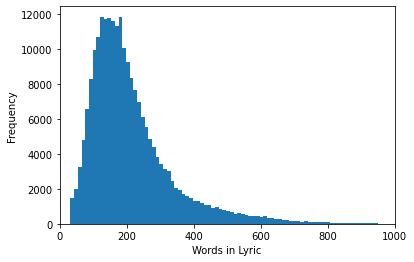

genres.cat.categories: Index(['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal',
       'Pop', 'R&B', 'Rock'],
      dtype='object')
Done


In [ ]:
train_df = pd.read_csv(
    os.path.join(WORKDIR, 'train_df.csv'))
# process the train_df
train_df = train_df.astype('string')
train_df = train_df[~train_df['Lyrics'].isnull()] # remove the ones with <NA> lyrics

# executive decision #1 remvoing the lyrics which are shorter than 30 words
# it does't seem like a song to me, plus hard to evaluate and my skew my model
# https://www.mentalfloss.com/article/19005/music-7-songs-fewer-35-words
# says You Are So Beautiful by Joe Cocker, Rat Charles etc. is 31 words, so making my threshold 31
train_df = train_df[~train_df["Lyrics"].str.split(" ").apply(lambda x : len(x) < 32)]

# Visualise the Lyrics column in term of words
print(train_df["Lyrics"].str.split(" ").apply(len).describe())
train_df["Lyrics"].str.split(" ").apply(len).plot.hist(bins=250, xlim=(0,1000))
plt.xlabel('Words in Lyric')
plt.show()

# we will need the order of the cateogries again when fetching the model
train_df["Genre"] = train_df["Genre"].astype("category")
print("genres.cat.categories:", train_df["Genre"].cat.categories)
with open(os.path.join(WORKDIR, 'categories.pickle'), 'wb') as f:
    pickle.dump(train_df["Genre"].cat.categories.to_list(), f)


# we need to find out what is our vocab dict, will be max 10,000 words
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

# find all the vocab on the training set, wouldn't seem fair to use test set
vectorize_layer.adapt(train_df["Lyrics"])
all_vocab = vectorize_layer.get_vocabulary()
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'wb') as f:
    pickle.dump(all_vocab[2:], f)
    
    
training_df, validation_df = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["Genre"].values,
    shuffle=True
)

train_lyrics = training_df["Lyrics"].to_numpy()
train_genres = training_df["Genre"].cat.codes.to_numpy()

val_lyrics = validation_df["Lyrics"].to_numpy()
val_genres = validation_df["Genre"].cat.codes.to_numpy()

with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'wb') as f:
    pickle.dump([train_lyrics, train_genres, val_lyrics, val_genres], f)
print("Done")


In [6]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)
print(pd.Series(train_lyrics).str.split(" ").apply(len).describe())

count    201191.000000
mean        213.895482
std         129.994572
min          32.000000
25%         129.000000
50%         182.000000
75%         258.000000
max        2801.000000
dtype: float64


## 1. No RNN/LSTM just TF-IDF with 2 ngrams

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=2,
    output_mode="tf_idf",
    max_tokens=VOCAB_SIZE)
lyrics_df = pd.DataFrame(train_lyrics, columns = ['Lyrics'])
vectorize_layer.adapt(lyrics_df["Lyrics"])

# Pickle the config and weights
# https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow
with open(os.path.join(WORKDIR, 'tf_idf_vectorize_layer.pickle'), 'wb') as f:
  pickle.dump({'config': vectorize_layer.get_config(),
              'weights': vectorize_layer.get_weights()}, f)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_9 (TextV  (None, 10000)            1         
 ectorization)                                                   
                                                                 
 dense_37 (Dense)            (None, 16)                160016    
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_38 (Dense)            (None, 10)                170       
                                                                 
Total params: 160,187
Trainable params: 160,186
Non-trainable params: 1
_________________________________________________________________
Epoch 1/10
1569/1572 [============================>.] - ETA: 0s - loss: 1.8679 - accuracy: 0.5119
Epoch 1: val_lo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


1572/1572 [==============================] - 32s 20ms/step - loss: 1.8672 - accuracy: 0.5119 - val_loss: 1.1905 - val_accuracy: 0.6092
Epoch 2/10
1569/1572 [============================>.] - ETA: 0s - loss: 1.1977 - accuracy: 0.5963
Epoch 2: val_loss improved from 1.19047 to 1.14197, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


1572/1572 [==============================] - 24s 16ms/step - loss: 1.1977 - accuracy: 0.5964 - val_loss: 1.1420 - val_accuracy: 0.6144
Epoch 3/10
1569/1572 [============================>.] - ETA: 0s - loss: 1.1514 - accuracy: 0.6047
Epoch 3: val_loss improved from 1.14197 to 1.13525, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


1572/1572 [==============================] - 25s 16ms/step - loss: 1.1514 - accuracy: 0.6047 - val_loss: 1.1352 - val_accuracy: 0.6175
Epoch 4/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1356 - accuracy: 0.6071
Epoch 4: val_loss improved from 1.13525 to 1.12833, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


1572/1572 [==============================] - 25s 16ms/step - loss: 1.1356 - accuracy: 0.6071 - val_loss: 1.1283 - val_accuracy: 0.6183
Epoch 5/10
1570/1572 [============================>.] - ETA: 0s - loss: 1.1233 - accuracy: 0.6103
Epoch 5: val_loss did not improve from 1.12833
1572/1572 [==============================] - 23s 15ms/step - loss: 1.1234 - accuracy: 0.6102 - val_loss: 1.1300 - val_accuracy: 0.6152
Epoch 6/10
1569/1572 [============================>.] - ETA: 0s - loss: 1.1142 - accuracy: 0.6127
Epoch 6: val_loss improved from 1.12833 to 1.12652, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_multi_hot_2ngram_1/assets


1572/1572 [==============================] - 24s 15ms/step - loss: 1.1144 - accuracy: 0.6127 - val_loss: 1.1265 - val_accuracy: 0.6204
Epoch 7/10
1570/1572 [============================>.] - ETA: 0s - loss: 1.1046 - accuracy: 0.6156
Epoch 7: val_loss did not improve from 1.12652
1572/1572 [==============================] - 24s 15ms/step - loss: 1.1047 - accuracy: 0.6155 - val_loss: 1.1318 - val_accuracy: 0.6197
Epoch 8/10
1569/1572 [============================>.] - ETA: 0s - loss: 1.0993 - accuracy: 0.6175
Epoch 8: val_loss did not improve from 1.12652
1572/1572 [==============================] - 23s 15ms/step - loss: 1.0992 - accuracy: 0.6175 - val_loss: 1.1365 - val_accuracy: 0.6169
Epoch 9/10
1569/1572 [============================>.] - ETA: 0s - loss: 1.0943 - accuracy: 0.6181
Epoch 9: val_loss did not improve from 1.12652
1572/1572 [==============================] - 23s 15ms/step - loss: 1.0943 - accuracy: 0.6181 - val_loss: 1.1290 - val_accuracy: 0.6197
Epoch 10/10
1569/1572 [==

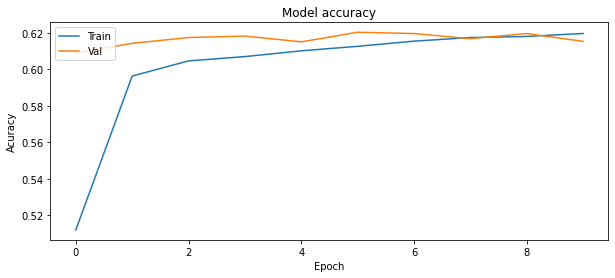

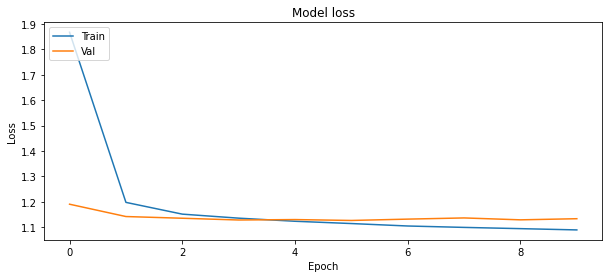

782/782 [==============================] - 4s 5ms/step
[[   0    0    0    0    0    3    0   19    0  167]
 [   0    0    0    0    0    0   11   68    0  121]
 [   0    0   13    0    1   29    4   78    0  692]
 [   0    0    0    0    0    2    6  195    0   21]
 [   0    0    1    0    5    9   16  171    0  522]
 [   0    0    1    1    1  550    4  138    0  636]
 [   0    0    1    0    0    3  662  236    0 1011]
 [   0    0    2    0    0  113  102 5214    1 3198]
 [   0    0    2    0    0    3    1  129    0  142]
 [   0    0   19    0    0  149  212 1377    0 8958]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       189
  Electronic       0.00      0.00      0.00       200
        Folk       0.33      0.02      0.03       817
     Hip-Hop       0.00      0.00      0.00       224
       Indie       0.71      0.01      0.01       724
        Jazz       0.64      0.41      0.50      1331
       Metal       0.65      0.35  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


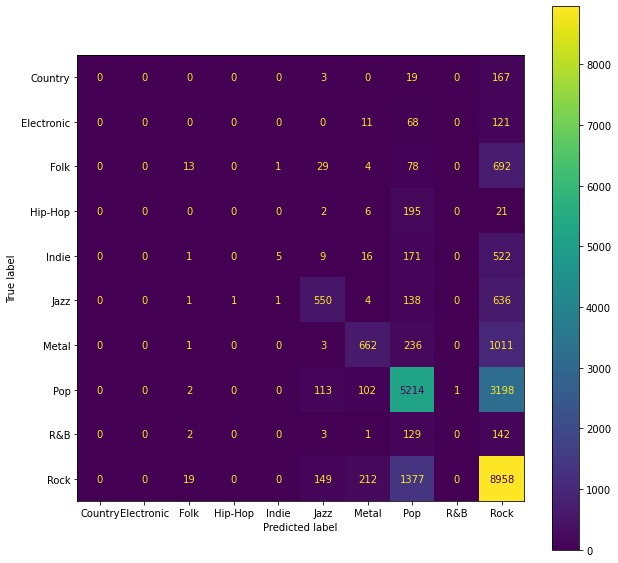

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)
save_name = "train_model_multi_hot_2ngram_1"
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
    
# from https://stackoverflow.com/questions/65103526/how-to-save-textvectorization-to-disk-in-tensorflow
with open(os.path.join(WORKDIR, 'tf_idf_vectorize_layer.pickle'), 'rb') as f:  
    from_disk = pickle.load(f)
    vectorize_layer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
    # You have to call `adapt` with some dummy data (BUG in Keras)
    vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    vectorize_layer.set_weights(from_disk['weights'])

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Dense(16))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))

test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()



## 2. Basic RNN


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_9 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 200, 50)           500000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 80)                10480     
                                                                 
 dense_31 (Dense)            (None, 10)                810       
                                                                 
Total params: 511,290
Trainable params: 511,290
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1572/1572 [==============================] - ETA: 0s - loss: 1.4169 - accuracy: 0.4676
Epoch 1: val_lo

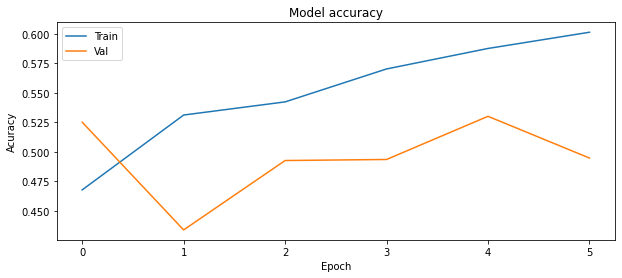

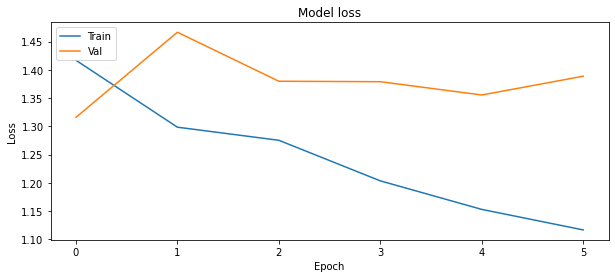

782/782 [==============================] - 16s 20ms/step
[[   0    0    0    0    0    1    1    8    0  179]
 [   0    0    0    0    0    0   15   38    0  147]
 [   0    0    0    0    0    6   25   41    0  745]
 [   0    0    0    0    0    0    1  165    0   58]
 [   0    0    0    0    0    3   28   95    0  598]
 [   0    0    0    0    0  242    6   65    0 1018]
 [   0    0    0    0    0    1  389  150    0 1373]
 [   0    0    0    0    0   23  151 3036    0 5420]
 [   0    0    0    0    0    0    5   44    0  228]
 [   0    0    0    0    0   24  413  745    0 9533]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       189
  Electronic       0.00      0.00      0.00       200
        Folk       0.00      0.00      0.00       817
     Hip-Hop       0.00      0.00      0.00       224
       Indie       0.00      0.00      0.00       724
        Jazz       0.81      0.18      0.30      1331
       Metal       0.38      0.20

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


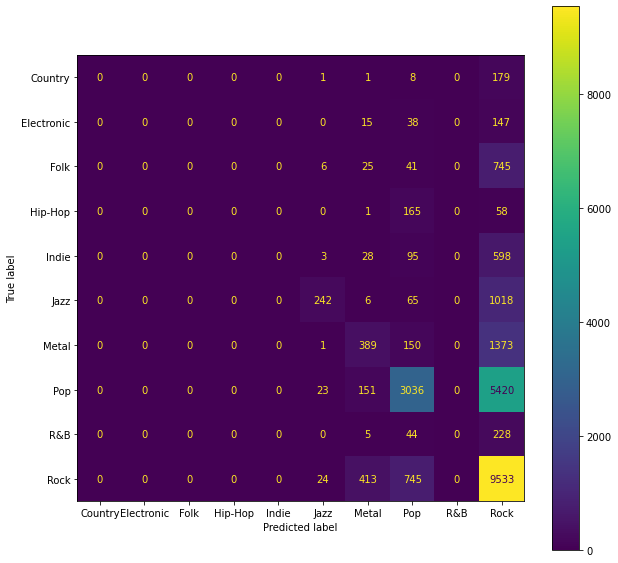

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

save_name = "train_model_basic_rnn"

with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, 50, input_length=MAX_SEQUENCE_LENGTH, 
                                    # Use masking to handle the variable sequence lengths
                                    mask_zero=True))
model.add(tf.keras.layers.SimpleRNN(80))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))

test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## 3. LSTM (same as 2. but LSTM :) )

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_19 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_11 (Embedding)    (None, 200, 50)           500000    
                                                                 
 lstm_single (LSTM)          (None, 80)                41920     
                                                                 
 dense_41 (Dense)            (None, 10)                810       
                                                                 
Total params: 542,730
Trainable params: 542,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.3690 - accuracy: 0.5037
Epoch 1: val_lo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


1572/1572 [==============================] - 66s 39ms/step - loss: 1.3689 - accuracy: 0.5037 - val_loss: 1.2436 - val_accuracy: 0.5628
Epoch 2/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1612 - accuracy: 0.6016
Epoch 2: val_loss improved from 1.24363 to 1.14394, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


1572/1572 [==============================] - 59s 38ms/step - loss: 1.1612 - accuracy: 0.6016 - val_loss: 1.1439 - val_accuracy: 0.6058
Epoch 3/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.0853 - accuracy: 0.6356
Epoch 3: val_loss improved from 1.14394 to 1.10996, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


1572/1572 [==============================] - 59s 37ms/step - loss: 1.0854 - accuracy: 0.6356 - val_loss: 1.1100 - val_accuracy: 0.6242
Epoch 4/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.0391 - accuracy: 0.6520
Epoch 4: val_loss improved from 1.10996 to 1.10361, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


1572/1572 [==============================] - 59s 37ms/step - loss: 1.0391 - accuracy: 0.6520 - val_loss: 1.1036 - val_accuracy: 0.6291
Epoch 5/10
1571/1572 [============================>.] - ETA: 0s - loss: 0.9969 - accuracy: 0.6674
Epoch 5: val_loss did not improve from 1.10361
1572/1572 [==============================] - 48s 31ms/step - loss: 0.9969 - accuracy: 0.6673 - val_loss: 1.1060 - val_accuracy: 0.6282
Epoch 6/10
1571/1572 [============================>.] - ETA: 0s - loss: 0.9555 - accuracy: 0.6817
Epoch 6: val_loss improved from 1.10361 to 1.09909, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_lstm/assets


1572/1572 [==============================] - 60s 38ms/step - loss: 0.9555 - accuracy: 0.6817 - val_loss: 1.0991 - val_accuracy: 0.6320
Epoch 7/10
1571/1572 [============================>.] - ETA: 0s - loss: 0.9145 - accuracy: 0.6956
Epoch 7: val_loss did not improve from 1.09909
1572/1572 [==============================] - 48s 30ms/step - loss: 0.9145 - accuracy: 0.6956 - val_loss: 1.1120 - val_accuracy: 0.6307
Epoch 8/10
1571/1572 [============================>.] - ETA: 0s - loss: 0.8731 - accuracy: 0.7096
Epoch 8: val_loss did not improve from 1.09909
1572/1572 [==============================] - 47s 30ms/step - loss: 0.8732 - accuracy: 0.7096 - val_loss: 1.1290 - val_accuracy: 0.6310
Epoch 9/10
1572/1572 [==============================] - ETA: 0s - loss: 0.8342 - accuracy: 0.7232
Epoch 9: val_loss did not improve from 1.09909
1572/1572 [==============================] - 51s 32ms/step - loss: 0.8342 - accuracy: 0.7232 - val_loss: 1.1574 - val_accuracy: 0.6272
Epoch 10/10
1572/1572 [==

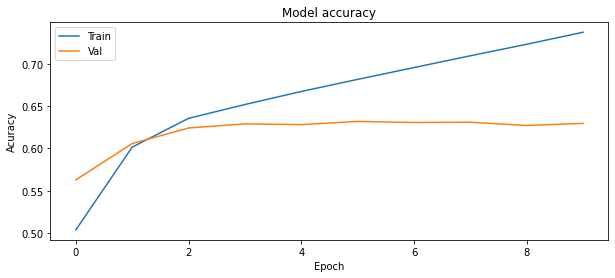

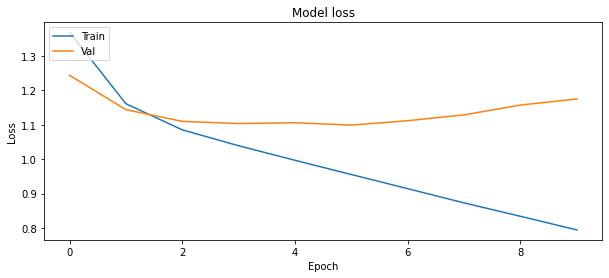

782/782 [==============================] - 6s 6ms/step
[[   0    0    2    0    0    4    1   21    0  161]
 [   0    0    0    1    0    0   17   84    0   98]
 [   0    0   61    0    0   31   10   84    0  631]
 [   0    0    0    7    1    2    3  188    0   23]
 [   0    0    8    6   20   11   23  179    0  477]
 [   0    0    7    2    1  709   10  130    0  472]
 [   0    0    0    2    1    3  938  220    0  749]
 [   0    0   21   22    5  111  162 5430    0 2879]
 [   0    0    1    0    0    3    6  127    0  140]
 [   0    0   62    4   13  186  340 1565    0 8545]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       189
  Electronic       0.00      0.00      0.00       200
        Folk       0.38      0.07      0.12       817
     Hip-Hop       0.16      0.03      0.05       224
       Indie       0.49      0.03      0.05       724
        Jazz       0.67      0.53      0.59      1331
       Metal       0.62      0.49  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


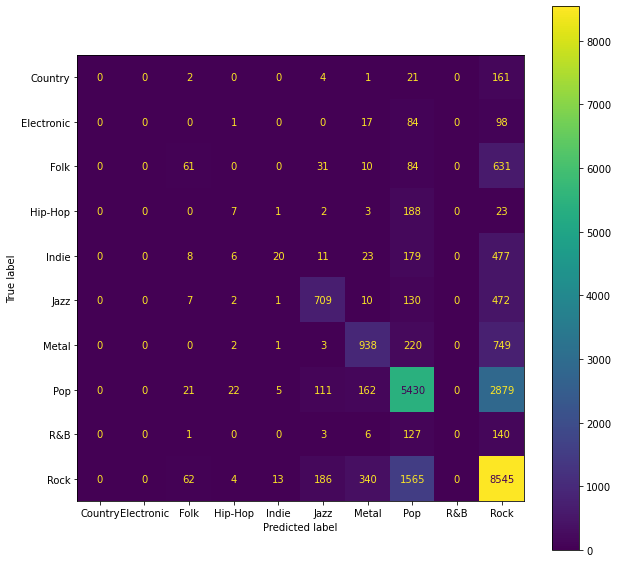

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

save_name = "train_model_lstm"

with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, 50, input_length=MAX_SEQUENCE_LENGTH, 
                                    # Use masking to handle the variable sequence lengths
                                    mask_zero=True))
model.add(tf.keras.layers.LSTM(80, name="lstm_single"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))

test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## 4. Double LSTM (same as 3.  but double :) )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 50)           500000    
                                                                 
 lstm1 (LSTM)                (None, 200, 160)          135040    
                                                                 
 lstm2 (LSTM)                (None, 80)                77120     
                                                                 
 dense (Dense)               (None, 10)                810       
                                                                 
Total params: 712,970
Trainable params: 712,970
Non-trainable params: 0
__________________________________________________

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


1572/1572 [==============================] - 123s 70ms/step - loss: 1.4148 - accuracy: 0.4863 - val_loss: 1.3266 - val_accuracy: 0.5372
Epoch 2/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.2109 - accuracy: 0.5820
Epoch 2: val_loss improved from 1.32657 to 1.14990, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


1572/1572 [==============================] - 105s 67ms/step - loss: 1.2109 - accuracy: 0.5820 - val_loss: 1.1499 - val_accuracy: 0.6062
Epoch 3/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1134 - accuracy: 0.6253
Epoch 3: val_loss improved from 1.14990 to 1.13737, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


1572/1572 [==============================] - 104s 66ms/step - loss: 1.1135 - accuracy: 0.6253 - val_loss: 1.1374 - val_accuracy: 0.6162
Epoch 4/10
1572/1572 [==============================] - ETA: 0s - loss: 1.0683 - accuracy: 0.6432
Epoch 4: val_loss improved from 1.13737 to 1.10354, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


1572/1572 [==============================] - 104s 66ms/step - loss: 1.0683 - accuracy: 0.6432 - val_loss: 1.1035 - val_accuracy: 0.6306
Epoch 5/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.0300 - accuracy: 0.6580
Epoch 5: val_loss improved from 1.10354 to 1.09017, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_double_lstm/assets


1572/1572 [==============================] - 104s 66ms/step - loss: 1.0299 - accuracy: 0.6580 - val_loss: 1.0902 - val_accuracy: 0.6343
Epoch 6/10
1571/1572 [============================>.] - ETA: 0s - loss: 0.9908 - accuracy: 0.6727
Epoch 6: val_loss did not improve from 1.09017
1572/1572 [==============================] - 78s 50ms/step - loss: 0.9908 - accuracy: 0.6727 - val_loss: 1.0916 - val_accuracy: 0.6315
Epoch 7/10
1571/1572 [============================>.] - ETA: 0s - loss: 0.9509 - accuracy: 0.6872
Epoch 7: val_loss did not improve from 1.09017
1572/1572 [==============================] - 79s 50ms/step - loss: 0.9509 - accuracy: 0.6872 - val_loss: 1.0936 - val_accuracy: 0.6380
Epoch 8/10
1571/1572 [============================>.] - ETA: 0s - loss: 0.9095 - accuracy: 0.7028
Epoch 8: val_loss did not improve from 1.09017
1572/1572 [==============================] - 78s 50ms/step - loss: 0.9094 - accuracy: 0.7028 - val_loss: 1.1128 - val_accuracy: 0.6359
Epoch 9/10
1571/1572 [==

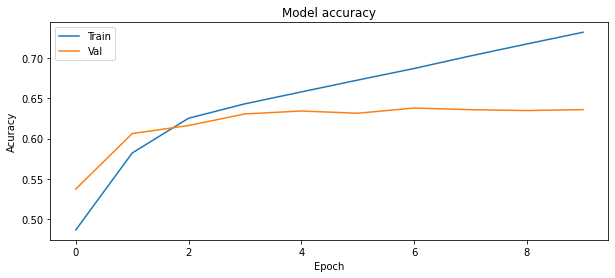

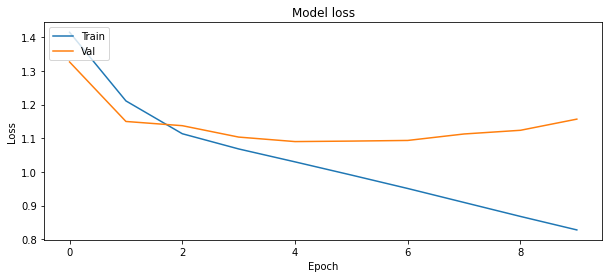

782/782 [==============================] - 12s 12ms/step
[[   0    0    0    0    0    7    0   19    0  163]
 [   0    0    0    0    0    0   17   72    0  111]
 [   0    0    4    0    0   33    9   60    0  711]
 [   0    0    0    0    0    0    8  198    0   18]
 [   0    0    0    0    0    8   23  191    0  502]
 [   0    0    2    0    0  695    8  138    0  488]
 [   0    0    0    0    0    2  891  259    0  761]
 [   0    0    1    0    0  120  156 5381    0 2972]
 [   0    0    0    0    0    2    8  128    0  139]
 [   0    0    3    0    0  162  316 1499    0 8735]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       189
  Electronic       0.00      0.00      0.00       200
        Folk       0.40      0.00      0.01       817
     Hip-Hop       0.00      0.00      0.00       224
       Indie       0.00      0.00      0.00       724
        Jazz       0.68      0.52      0.59      1331
       Metal       0.62      0.47

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


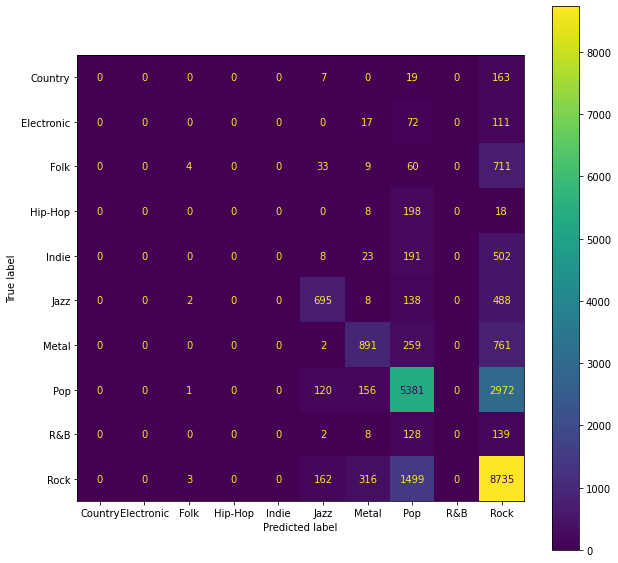

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

save_name = "train_model_double_lstm"

with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, 50, input_length=MAX_SEQUENCE_LENGTH, 
                                    # Use masking to handle the variable sequence lengths
                                    mask_zero=True))
model.add(tf.keras.layers.LSTM(160,  return_sequences=True, name="lstm1"))
model.add(tf.keras.layers.LSTM(80, name="lstm2"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))
test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## 5. Bidirectional LSTM using pretrained GloVe: Global Vectors for Word Representation 
https://nlp.stanford.edu/projects/glove/

Found 400000 word vectors.
Converted 9606 words (394 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 200, 100)          1000200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 10)                650       
                                                          

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 70s 42ms/step - loss: 1.3604 - accuracy: 0.5223 - val_loss: 1.2437 - val_accuracy: 0.5572
Epoch 2/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.2543 - accuracy: 0.5613
Epoch 2: val_loss improved from 1.24374 to 1.20225, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 65s 42ms/step - loss: 1.2543 - accuracy: 0.5613 - val_loss: 1.2023 - val_accuracy: 0.5804
Epoch 3/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.2196 - accuracy: 0.5753
Epoch 3: val_loss improved from 1.20225 to 1.17936, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 66s 42ms/step - loss: 1.2197 - accuracy: 0.5753 - val_loss: 1.1794 - val_accuracy: 0.5914
Epoch 4/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1994 - accuracy: 0.5838
Epoch 4: val_loss improved from 1.17936 to 1.17023, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 66s 42ms/step - loss: 1.1994 - accuracy: 0.5838 - val_loss: 1.1702 - val_accuracy: 0.5919
Epoch 5/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1839 - accuracy: 0.5903
Epoch 5: val_loss improved from 1.17023 to 1.15877, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 65s 42ms/step - loss: 1.1839 - accuracy: 0.5903 - val_loss: 1.1588 - val_accuracy: 0.5976
Epoch 6/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1715 - accuracy: 0.5960
Epoch 6: val_loss improved from 1.15877 to 1.15237, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 65s 42ms/step - loss: 1.1715 - accuracy: 0.5960 - val_loss: 1.1524 - val_accuracy: 0.5984
Epoch 7/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1626 - accuracy: 0.5993
Epoch 7: val_loss improved from 1.15237 to 1.14091, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 66s 42ms/step - loss: 1.1627 - accuracy: 0.5992 - val_loss: 1.1409 - val_accuracy: 0.6044
Epoch 8/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1536 - accuracy: 0.6023
Epoch 8: val_loss improved from 1.14091 to 1.13894, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 66s 42ms/step - loss: 1.1535 - accuracy: 0.6023 - val_loss: 1.1389 - val_accuracy: 0.6052
Epoch 9/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1474 - accuracy: 0.6046
Epoch 9: val_loss improved from 1.13894 to 1.13598, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 67s 42ms/step - loss: 1.1475 - accuracy: 0.6046 - val_loss: 1.1360 - val_accuracy: 0.6085
Epoch 10/10
1571/1572 [============================>.] - ETA: 0s - loss: 1.1398 - accuracy: 0.6081
Epoch 10: val_loss improved from 1.13598 to 1.13401, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_LSTM_with_embedding_pretrained_glove/assets


1572/1572 [==============================] - 66s 42ms/step - loss: 1.1398 - accuracy: 0.6081 - val_loss: 1.1340 - val_accuracy: 0.6074


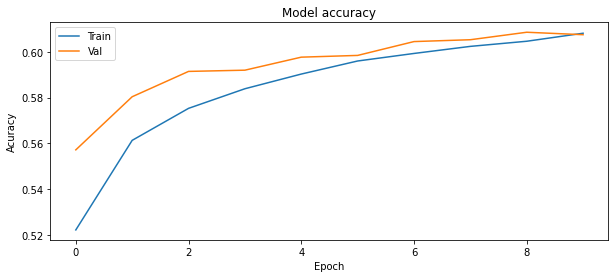

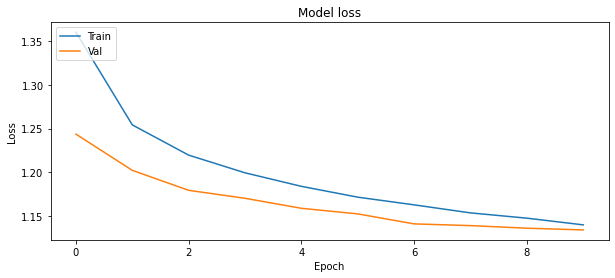

782/782 [==============================] - 7s 8ms/step
[[   0    0    0    0    0    3    0   19    0  167]
 [   0    0    0    0    0    1   11   58    0  130]
 [   0    0    0    0    0    9   10   36    0  762]
 [   0    0    0    0    0    0    5  189    0   30]
 [   0    0    0    0    0    5   13  129    0  577]
 [   0    0    0    0    0  447    5  106    0  773]
 [   0    0    0    0    0    1  723  192    0  997]
 [   0    0    0    0    0   56   86 4701    0 3787]
 [   0    0    0    0    0    1    3  115    0  158]
 [   0    0    0    0    0   81  260 1186    0 9188]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       189
  Electronic       0.00      0.00      0.00       200
        Folk       0.00      0.00      0.00       817
     Hip-Hop       0.00      0.00      0.00       224
       Indie       0.00      0.00      0.00       724
        Jazz       0.74      0.34      0.46      1331
       Metal       0.65      0.38  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


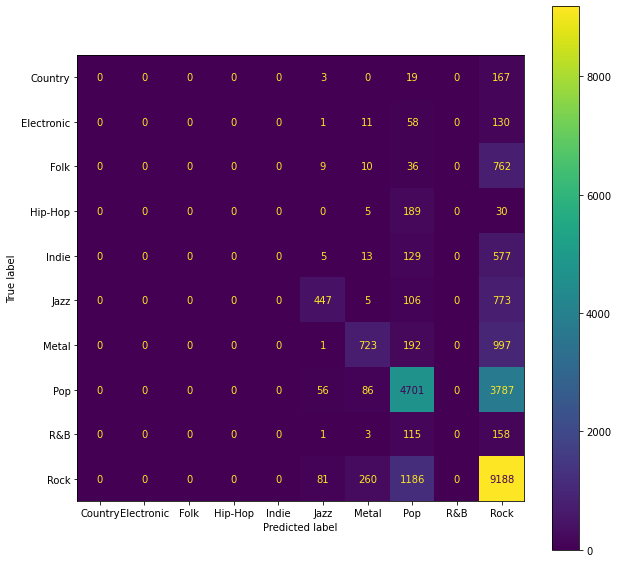

In [ ]:
def create_embedding_pretrained(vectorize_layer):
    """
    taken from https://keras.io/examples/nlp/pretrained_word_embeddings/
    """
    # !wget http://nlp.stanford.edu/data/glove.6B.zip
    # !unzip -q glove.6B.zip glove.6B.100d.txt

    path_to_glove_file = os.path.join(
        WORKDIR,"glove.6B.100d.txt"
    )
    
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    
    print("Found %s word vectors." % len(embeddings_index))

    voc = vectorize_layer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
    num_tokens = len(voc) + 2
    embedding_dim = 100
    hits = 0
    misses = 0
    
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))


    embedding_layer = tf.keras.layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )
    
    return embedding_layer

with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)


save_name = "train_model_LSTM_with_embedding_pretrained_glove"
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

glove_embedding_layer = create_embedding_pretrained(vectorize_layer) 
embedding_size=100 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(glove_embedding_layer)
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))
test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()
    

## 6. Time for a CNN with learned embedding 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_10 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 conv1d_13 (Conv1D)          (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,065,418
Trainable params: 1,065,418
No

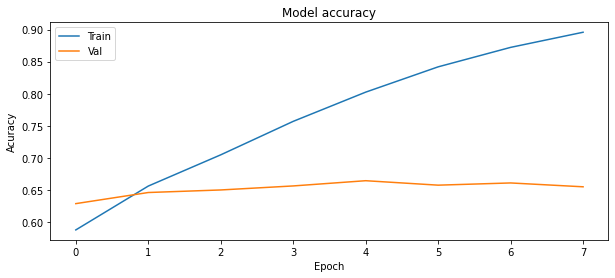

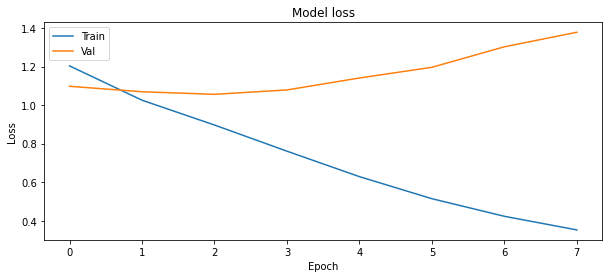

782/782 [==============================] - 3s 4ms/step
[[   0    0    5    0    0    3    0   36    0  145]
 [   0    0    1    0    0    1   17  108    0   73]
 [   0    0   93    0    0   29   11  175    0  509]
 [   0    0    0    1    0    0    7  200    0   16]
 [   0    0   13    0   22   11   30  282    0  366]
 [   0    0   15    0    1  683    6  267    0  359]
 [   0    0    6    0    2    1  979  321    0  604]
 [   0    0   25    2    2   95  143 6425    0 1938]
 [   0    0    1    0    0    7   10  156    6   97]
 [   0    0   64    2    5  133  310 2367    0 7834]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       189
  Electronic       0.00      0.00      0.00       200
        Folk       0.42      0.11      0.18       817
     Hip-Hop       0.20      0.00      0.01       224
       Indie       0.69      0.03      0.06       724
        Jazz       0.71      0.51      0.60      1331
       Metal       0.65      0.51  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


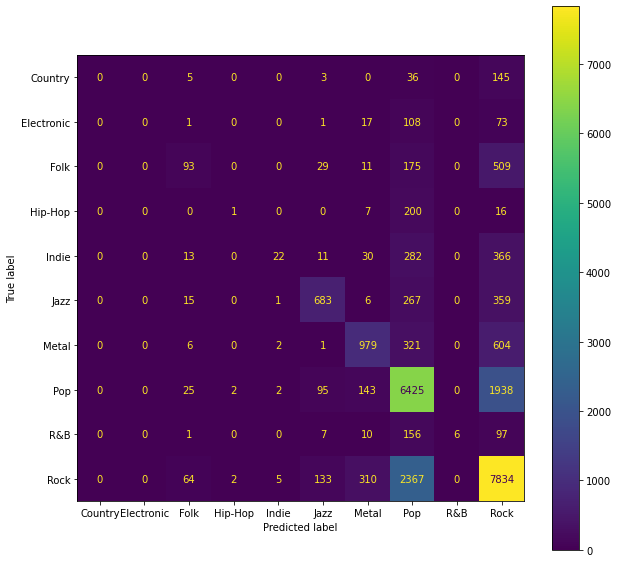

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

save_name = "train_model_embedding_with_cnn"
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

embedding_size=100 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_size,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))
test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## 7. same as the last but with dropout to stop overfittings

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_14 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_6 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 10)              

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting/assets


1572/1572 [==============================] - 33s 21ms/step - loss: 1.2815 - accuracy: 0.5603 - val_loss: 1.1398 - val_accuracy: 0.6171
Epoch 2/10
1570/1572 [============================>.] - ETA: 0s - loss: 1.1355 - accuracy: 0.6173
Epoch 2: val_loss improved from 1.13979 to 1.10583, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting/assets


1572/1572 [==============================] - 33s 21ms/step - loss: 1.1355 - accuracy: 0.6173 - val_loss: 1.1058 - val_accuracy: 0.6289
Epoch 3/10
1570/1572 [============================>.] - ETA: 0s - loss: 1.0687 - accuracy: 0.6409
Epoch 3: val_loss improved from 1.10583 to 1.09573, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting/assets


1572/1572 [==============================] - 34s 21ms/step - loss: 1.0686 - accuracy: 0.6409 - val_loss: 1.0957 - val_accuracy: 0.6346
Epoch 4/10
1570/1572 [============================>.] - ETA: 0s - loss: 1.0104 - accuracy: 0.6619
Epoch 4: val_loss improved from 1.09573 to 1.08213, saving model to /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting
INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DEEP_LEARNING_LYRICS_HOUSE_MD/train_model_embedding_with_cnn_stopoverfitting/assets


1572/1572 [==============================] - 33s 21ms/step - loss: 1.0104 - accuracy: 0.6619 - val_loss: 1.0821 - val_accuracy: 0.6433
Epoch 5/10
1570/1572 [============================>.] - ETA: 0s - loss: 0.9566 - accuracy: 0.6798
Epoch 5: val_loss did not improve from 1.08213
1572/1572 [==============================] - 31s 20ms/step - loss: 0.9568 - accuracy: 0.6797 - val_loss: 1.0847 - val_accuracy: 0.6481
Epoch 6/10
1570/1572 [============================>.] - ETA: 0s - loss: 0.9070 - accuracy: 0.6967
Epoch 6: val_loss did not improve from 1.08213
1572/1572 [==============================] - 31s 20ms/step - loss: 0.9070 - accuracy: 0.6968 - val_loss: 1.0961 - val_accuracy: 0.6527
Epoch 7/10
1570/1572 [============================>.] - ETA: 0s - loss: 0.8622 - accuracy: 0.7116
Epoch 7: val_loss did not improve from 1.08213
1572/1572 [==============================] - 31s 20ms/step - loss: 0.8623 - accuracy: 0.7116 - val_loss: 1.1086 - val_accuracy: 0.6536
Epoch 8/10
1572/1572 [===

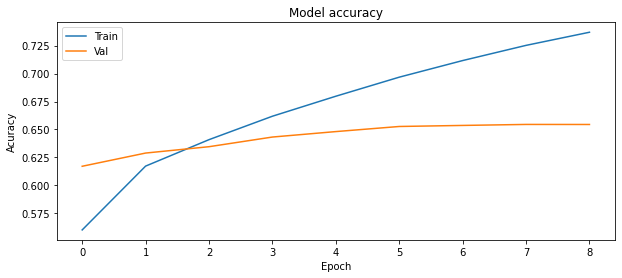

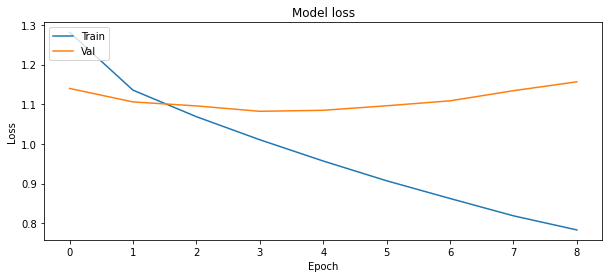

782/782 [==============================] - 2s 3ms/step
[[   0    0    0    0    0    3    0   24    0  162]
 [   0    0    0    0    0    0   15   88    0   97]
 [   0    0    9    0    0   26    5   84    0  693]
 [   0    0    0    1    0    0    2  205    0   16]
 [   0    0    0    0    8    6   15  220    0  475]
 [   0    0    1    0    0  648    7  186    0  489]
 [   0    0    0    1    0    2  861  289    0  760]
 [   0    0    1    7    0   83  126 5726    0 2687]
 [   0    0    0    0    0    4    2  147    0  124]
 [   0    0    3    0    0  116  267 1719    0 8610]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       189
  Electronic       0.00      0.00      0.00       200
        Folk       0.64      0.01      0.02       817
     Hip-Hop       0.11      0.00      0.01       224
       Indie       1.00      0.01      0.02       724
        Jazz       0.73      0.49      0.58      1331
       Metal       0.66      0.45  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


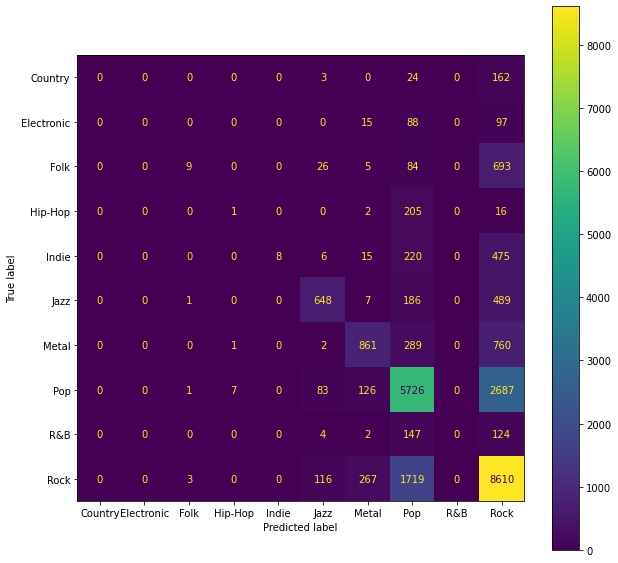

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

save_name = "train_model_embedding_with_cnn_stopoverfitting"
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

embedding_size=100 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_size,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))
test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

## 8. Non-neural method (sklearn)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


gs_clf_NB cv_results_:
 {'mean_fit_time': array([ 25.74398518,  71.12789688, 188.12309175,  22.24951496,
        85.53497076, 201.32013469]), 'std_fit_time': array([3.07733814, 1.15726919, 9.95399354, 0.27998613, 6.38397898,
       3.35076852]), 'mean_score_time': array([ 5.65094714,  9.38649888, 13.96517477,  6.08780966, 11.11173749,
       14.11932931]), 'std_score_time': array([0.14636397, 0.12547199, 0.33798909, 1.34106573, 2.08582165,
       0.57181559]), 'param_tfidf__use_idf': masked_array(data=[True, True, True, False, False, False],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_vect__ngram_range': masked_array(data=[(1, 1), (1, 2), (1, 3), (1, 1), (1, 2), (1, 3)],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}, {'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}, {'tfidf__use

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SparseCategoricalAccuracy 0.5826938


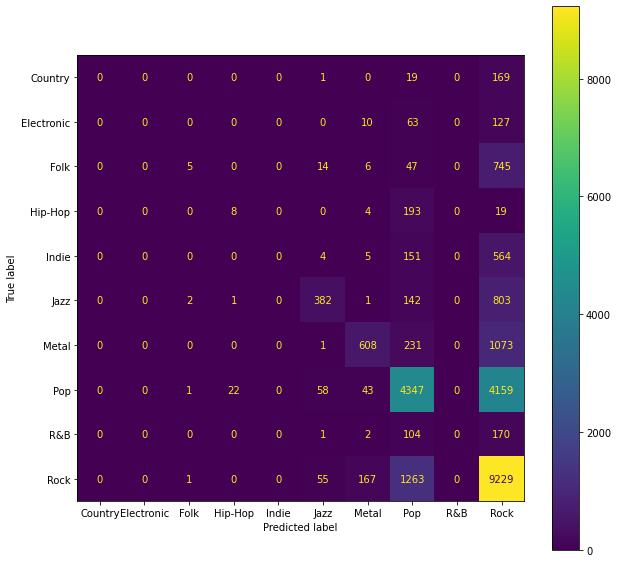

CPU times: user 2min 23s, sys: 10.4 s, total: 2min 34s
Wall time: 31min 4s


In [ ]:
%%time
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import string

with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)


from sklearn.model_selection import GridSearchCV
text_clf_NB = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords, max_features=10_000)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False)
}
gs_clf_NB = GridSearchCV(text_clf_NB, parameters, cv=5, n_jobs=2, verbose=2, scoring="accuracy")
gs_clf_NB.fit(train_lyrics, train_genres)


print("gs_clf_NB cv_results_:\n",gs_clf_NB.cv_results_)
print("gs_clf_NB best_estimator_:\n", gs_clf_NB.best_estimator_)


##########################################################################################
print("*"*100)
print("gs_clf_NB")
print("*"*100)
test_lyrics, test_genres = give_me_the_test_set()
test_preds = gs_clf_NB.predict(test_lyrics)
test_preds_proba = gs_clf_NB.predict_proba(test_lyrics)


from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, test_preds_proba)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()




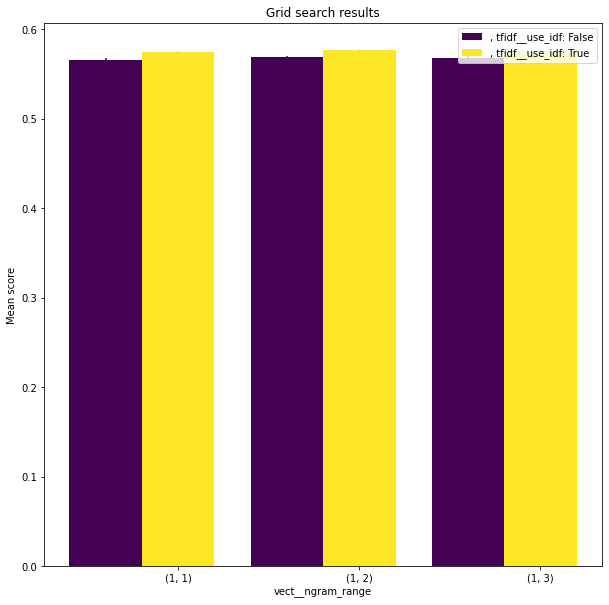

In [ ]:
from sklearn_evaluation import plot
fig, ax = plt.subplots(figsize=(10,10))
plot.grid_search(gs_clf_NB.cv_results_, change='vect__ngram_range', kind='bar', ax=ax)
plt.show()

## 9. Non-neural method (sklearn) (RandomUnderSampler)

Before resampling: (201191,) (201191,) (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([ 1531,  1598,  6585,  1813,  5796, 10721, 15322, 69492,  2227,
       86106]))
After resampling: (15310,) (15310,) (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([1531, 1531, 1531, 1531, 1531, 1531, 1531, 1531, 1531, 1531]))
Fitting 5 folds for each of 6 candidates, totalling 30 fits
gs_clf_NB_RS cv_results_:
 {'mean_fit_time': array([ 1.87263098,  7.13431029, 15.56667423,  1.82464032,  7.40256796,
       15.73220463]), 'std_fit_time': array([0.02091635, 0.06291338, 0.15104676, 0.01075557, 0.66108345,
       0.75420004]), 'mean_score_time': array([0.43734097, 0.73202896, 1.00094457, 0.42252207, 0.7275681 ,
       0.9829843 ]), 'std_score_time': array([0.00824195, 0.01495518, 0.01202106, 0.00825378, 0.01566844,
       0.00770323]), 'param_tfidf__use_idf': masked_array(data=[True, True, True, False, False, False],
             mask=[False, False, False, False, False, False],
     

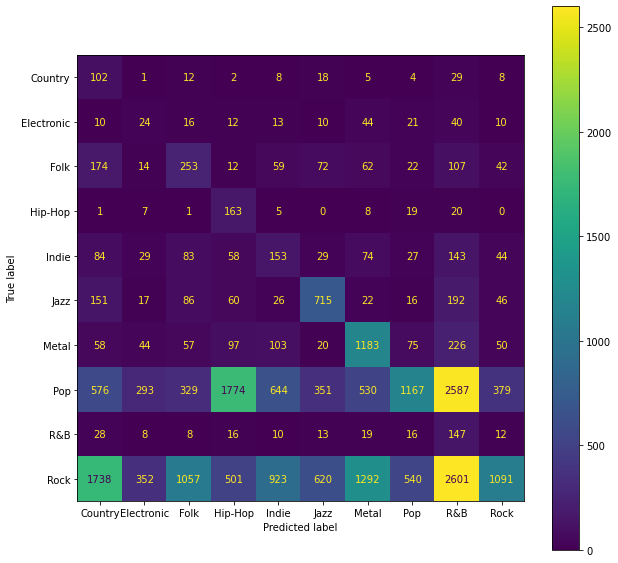

CPU times: user 13.6 s, sys: 608 ms, total: 14.2 s
Wall time: 2min 33s


In [ ]:
%%time
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import string

with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
print("Before resampling:", train_lyrics.shape, train_genres.shape, np.unique(train_genres, return_counts=True))
X_res, y_res = rus.fit_resample(np.expand_dims(train_lyrics, axis=1), np.expand_dims(train_genres, axis=1))
X_res = np.squeeze(X_res)
y_res = np.squeeze(y_res)
print("After resampling:", X_res.shape, y_res.shape, np.unique(y_res, return_counts=True))


from sklearn.model_selection import GridSearchCV
text_clf_NB = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords, max_features=10_000)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': (True, False)
}
gs_clf_NB_RS = GridSearchCV(text_clf_NB, parameters, cv=5, n_jobs=2, verbose=2, scoring="accuracy")
gs_clf_NB_RS.fit(X_res, y_res)


print("gs_clf_NB_RS cv_results_:\n",gs_clf_NB_RS.cv_results_)
print("gs_clf_NB_RS best_estimator_:\n", gs_clf_NB_RS.best_estimator_)


##########################################################################################
print("*"*100)
print("gs_clf_NB_RS")
print("*"*100)
test_lyrics, test_genres = give_me_the_test_set()
test_preds = gs_clf_NB_RS.predict(test_lyrics)
test_preds_proba = gs_clf_NB_RS.predict_proba(test_lyrics)


from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, test_preds_proba)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()


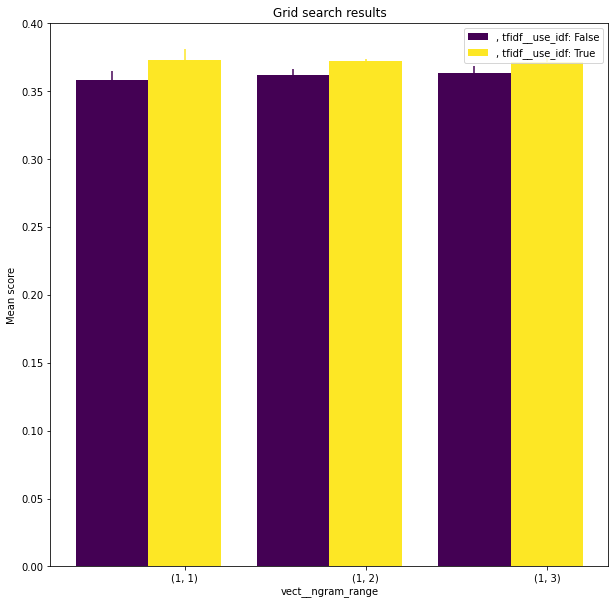

In [ ]:
from sklearn_evaluation import plot
fig, ax = plt.subplots(figsize=(10,10))
plot.grid_search(gs_clf_NB_RS.cv_results_, change='vect__ngram_range', kind='bar', ax=ax)
plt.show()

## 10. Best so far was CNN (balanced_accuracy_score 0.267) retraining this with balanced dataset to see if it helps

### (a) Under samplying

Before resampling: (201191,) (201191,) (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([ 1531,  1598,  6585,  1813,  5796, 10721, 15322, 69492,  2227,
       86106]))
After resampling: (15310,) (15310,) (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([1531, 1531, 1531, 1531, 1531, 1531, 1531, 1531, 1531, 1531]))
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)         

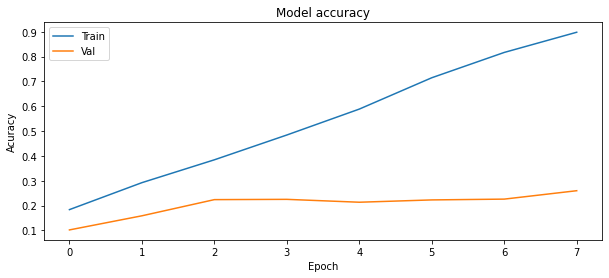

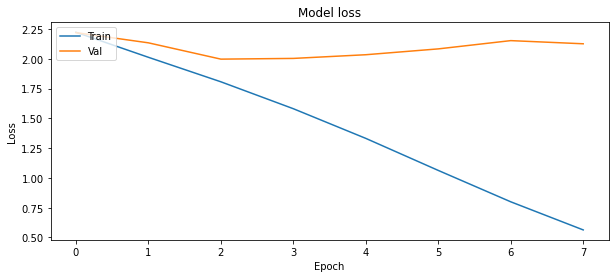

782/782 [==============================] - 2s 3ms/step
[[  70    3   31    3    5   34    7   13   10   13]
 [   8   26   17   16   20   18   40   17   26   12]
 [ 134   31  290   12   43   85   90   17   28   87]
 [   2    2    4  168    4    0   10   23   11    0]
 [  67   61  136   39   93   50  106   54   50   68]
 [ 174   34  166   55   30  680   25   39   94   34]
 [  69   98  146   80  102   29 1116  110   62  101]
 [ 541  469  618 1901  463  402  755 1755 1214  512]
 [  20    8   16   22   11   20   24   44   96   16]
 [1568  706 1660  344  746 1015 1570  792  986 1328]]
              precision    recall  f1-score   support

     Country       0.03      0.37      0.05       189
  Electronic       0.02      0.13      0.03       200
        Folk       0.09      0.35      0.15       817
     Hip-Hop       0.06      0.75      0.12       224
       Indie       0.06      0.13      0.08       724
        Jazz       0.29      0.51      0.37      1331
       Metal       0.30      0.58  

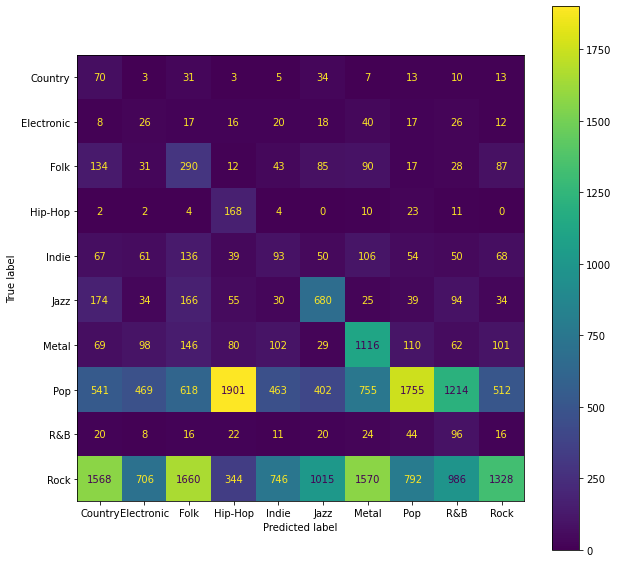

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
print("Before resampling:", train_lyrics.shape, train_genres.shape, np.unique(train_genres, return_counts=True))
X_res, y_res = rus.fit_resample(np.expand_dims(train_lyrics, axis=1), np.expand_dims(train_genres, axis=1))
train_lyrics = np.squeeze(X_res)
train_genres = np.squeeze(y_res)
print("After resampling:", train_lyrics.shape, train_genres.shape, np.unique(train_genres, return_counts=True))


save_name = "train_model_embedding_with_cnn_sampler"
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

embedding_size=100 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_size,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))
test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

### (b) Over samplying

Before resampling: (201191,) (201191,) (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([ 1531,  1598,  6585,  1813,  5796, 10721, 15322, 69492,  2227,
       86106]))
After resampling: (861060,) (861060,) (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([86106, 86106, 86106, 86106, 86106, 86106, 86106, 86106, 86106,
       86106]))
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_6 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_6 (Glo  (

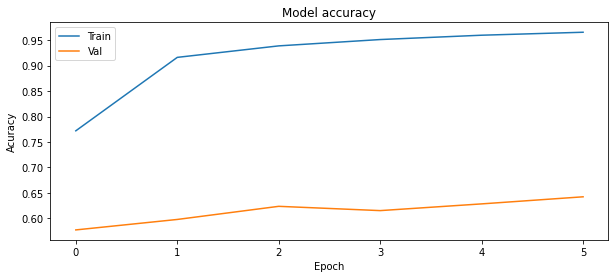

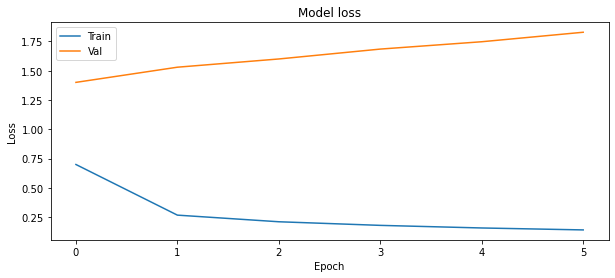

782/782 [==============================] - 2s 3ms/step
[[  18    0   14    0    2   18    2   13    3  119]
 [   0   15    7    2   10   11   27   50    0   78]
 [   8    3  214    0   31   63   28   40    5  425]
 [   0    0    0   18    5    4   10  152    6   29]
 [   4    4   24    1  141   27   59  102   11  351]
 [   8    7   36    3   22  884   12   87   37  235]
 [   3   12    9    1   31   16 1230  137    3  471]
 [  37   43  125  112  180  377  380 4559  138 2679]
 [   2    0    3    1    5   25   13   93   45   90]
 [ 180   43  287   19  260  608  814 1142  135 7227]]
              precision    recall  f1-score   support

     Country       0.07      0.10      0.08       189
  Electronic       0.12      0.07      0.09       200
        Folk       0.30      0.26      0.28       817
     Hip-Hop       0.11      0.08      0.09       224
       Indie       0.21      0.19      0.20       724
        Jazz       0.43      0.66      0.53      1331
       Metal       0.48      0.64  

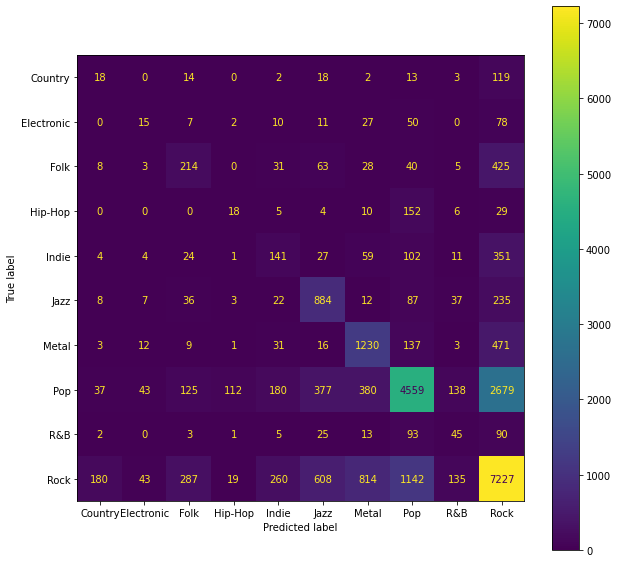

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
print("Before resampling:", train_lyrics.shape, train_genres.shape, np.unique(train_genres, return_counts=True))
X_res, y_res = rus.fit_resample(np.expand_dims(train_lyrics, axis=1), np.expand_dims(train_genres, axis=1))
train_lyrics = np.squeeze(X_res)
train_genres = np.squeeze(y_res)
print("After resampling:", train_lyrics.shape, train_genres.shape, np.unique(train_genres, return_counts=True))


save_name = "train_model_embedding_with_cnn_sampler_over"
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

embedding_size=100 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_size,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))
test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

# All Results

In [ ]:
models = ['## 1. No RNN/LSTM just TF-IDF with 2 ngrams', '## 2. Basic RNN', '## 3. LSTM (same as 2. but LSTM :) )', '## 4. Double LSTM (same as 3.  but double :) )', '## 5. Bidirectional LSTM using pretrained GloVe: Global Vectors for Word Representation', '## 6. Time for a CNN with learned embedding', '## 7. same as the last but with dropout to stop overfittings', '## 8. Non-neural method (sklearn)', '## 9. Non-neural method (sklearn) (RandomUnderSampler)','## 10. Best so far was CNN balanced dataset(a) Under samplying', '## 10. Best so far was CNN with balanced dataset (b) Over samplying','## 11. Trying CNN again with more 2 Conv1D']
models, len(models)

(['## 1. No RNN/LSTM just TF-IDF with 2 ngrams',
  '## 2. Basic RNN',
  '## 3. LSTM (same as 2. but LSTM :) )',
  '## 4. Double LSTM (same as 3.  but double :) )',
  '## 5. Bidirectional LSTM using pretrained GloVe: Global Vectors for Word Representation',
  '## 6. Time for a CNN with learned embedding',
  '## 7. same as the last but with dropout to stop overfittings',
  '## 8. Non-neural method (sklearn)',
  '## 9. Non-neural method (sklearn) (RandomUnderSampler)',
  '## 10. Best so far was CNN balanced dataset(a) Under samplying',
  '## 10. Best so far was CNN with balanced dataset (b) Over samplying',
  '## 11. Trying CNN again with more 2 Conv1D'],
 12)

In [ ]:
SparseCategoricalAccuracy_list = ['0.61558753', '0.52757794', '0.6278977', '0.6285771', '0.6018785', '0.64120704', '0.6340128', '0.5826938', '0.1997602', '0.22470024', '0.57358116', '0.62190247']
SparseCategoricalAccuracy_list, len(SparseCategoricalAccuracy_list)

(['0.61558753',
  '0.52757794',
  '0.6278977',
  '0.6285771',
  '0.6018785',
  '0.64120704',
  '0.6340128',
  '0.5826938',
  '0.1997602',
  '0.22470024',
  '0.57358116',
  '0.62190247'],
 12)

In [ ]:
balanced_accuracy_score_list = ['0.2222290169777203', '0.16266471268297353', '0.25832298630789763', '0.24608098800518413', '0.21159953185298805', '0.26708729412524496', '0.2430506174064802', '0.20116858034594448', '0.38316788566616367', '0.3501920700947467', '0.3379615339528475', '0.24387857210278274']
balanced_accuracy_score_list, len(balanced_accuracy_score_list)

(['0.2222290169777203',
  '0.16266471268297353',
  '0.25832298630789763',
  '0.24608098800518413',
  '0.21159953185298805',
  '0.26708729412524496',
  '0.2430506174064802',
  '0.20116858034594448',
  '0.38316788566616367',
  '0.3501920700947467',
  '0.3379615339528475',
  '0.24387857210278274'],
 12)

In [ ]:
results_df = pd.DataFrame({"models": models,
                        "SparseCategoricalAccuracy":SparseCategoricalAccuracy_list,
                        "balanced_accuracy_score": balanced_accuracy_score_list})
results_df["SparseCategoricalAccuracy"] = results_df["SparseCategoricalAccuracy"].astype('float64')
results_df["balanced_accuracy_score"] = results_df["balanced_accuracy_score"].astype('float64')
results_df["total_combined_score"] = results_df["balanced_accuracy_score"] + results_df["SparseCategoricalAccuracy"]
results_df

models  \
0         ## 1. No RNN/LSTM just TF-IDF with 2 ngrams   
1                                     ## 2. Basic RNN   
2                ## 3. LSTM (same as 2. but LSTM :) )   
3      ## 4. Double LSTM (same as 3.  but double :) )   
4   ## 5. Bidirectional LSTM using pretrained GloV...   
5         ## 6. Time for a CNN with learned embedding   
6   ## 7. same as the last but with dropout to sto...   
7                   ## 8. Non-neural method (sklearn)   
8   ## 9. Non-neural method (sklearn) (RandomUnder...   
9   ## 10. Best so far was CNN balanced dataset(a)...   
10  ## 10. Best so far was CNN with balanced datas...   
11         ## 11. Trying CNN again with more 2 Conv1D   

    SparseCategoricalAccuracy  balanced_accuracy_score  total_combined_score  
0                    0.615588                 0.222229              0.837817  
1                    0.527578                 0.162665              0.690243  
2                    0.627898                 0.258323              0.886221  
3                    0.628577                 0.246081              0.874658  
4                    0.601878                 0.211600              0.813478  
5                    0.641207                 0.267087              0.908294  
6                    0.634013                 0.243051              0.877063  
7                    0.582694                 0.201169              0.783862  
8                    0.199760                 0.383168              0.582928  
9                    0.224700                 0.350192              0.574892  
10                   0.573581                 0.337962              0.911543  
11                   0.621902                 0.243879              0.865781

In [ ]:
results_df.sort_values('total_combined_score')

models  \
9   ## 10. Best so far was CNN balanced dataset(a)...   
8   ## 9. Non-neural method (sklearn) (RandomUnder...   
1                                     ## 2. Basic RNN   
7                   ## 8. Non-neural method (sklearn)   
4   ## 5. Bidirectional LSTM using pretrained GloV...   
0         ## 1. No RNN/LSTM just TF-IDF with 2 ngrams   
11         ## 11. Trying CNN again with more 2 Conv1D   
3      ## 4. Double LSTM (same as 3.  but double :) )   
6   ## 7. same as the last but with dropout to sto...   
2                ## 3. LSTM (same as 2. but LSTM :) )   
5         ## 6. Time for a CNN with learned embedding   
10  ## 10. Best so far was CNN with balanced datas...   

    SparseCategoricalAccuracy  balanced_accuracy_score  total_combined_score  
9                    0.224700                 0.350192              0.574892  
8                    0.199760                 0.383168              0.582928  
1                    0.527578                 0.162665              0.690243  
7                    0.582694                 0.201169              0.783862  
4                    0.601878                 0.211600              0.813478  
0                    0.615588                 0.222229              0.837817  
11                   0.621902                 0.243879              0.865781  
3                    0.628577                 0.246081              0.874658  
6                    0.634013                 0.243051              0.877063  
2                    0.627898                 0.258323              0.886221  
5                    0.641207                 0.267087              0.908294  
10                   0.573581                 0.337962              0.911543

In [ ]:
results_df.to_csv(os.path.join(WORKDIR, 'results_df.csv'))

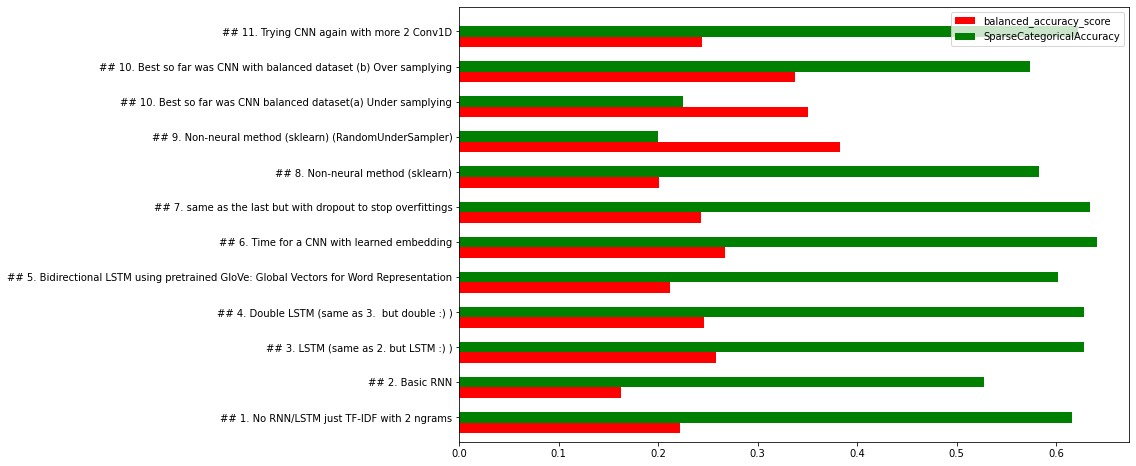

In [ ]:
ind = np.arange(len(results_df))
width = 0.3
# plt.figure(figsize=(12, 5))
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(ind, results_df.balanced_accuracy_score, width, color='red', label='balanced_accuracy_score')
ax.barh(ind + width, results_df.SparseCategoricalAccuracy, width, color='green', label='SparseCategoricalAccuracy')
ax.set(yticks=ind + width, yticklabels=results_df.models, ylim=[2*width - 1, len(results_df)])
ax.legend()
plt.show()

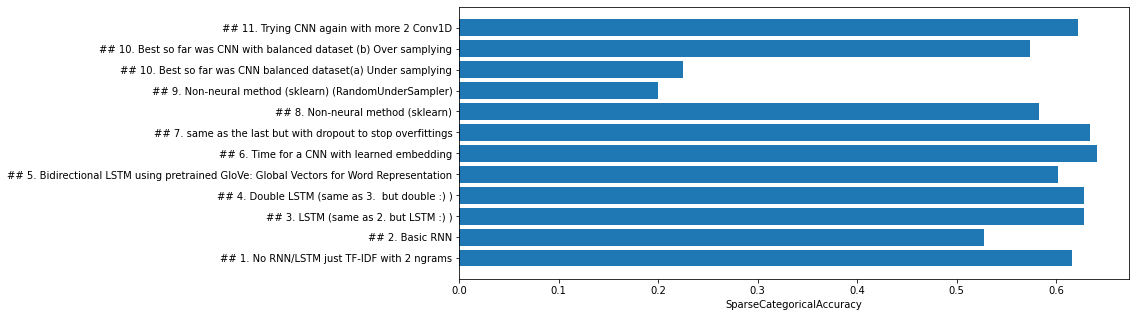

In [ ]:
y_pos = np.arange(len(results_df))
plt.figure(figsize=(12, 5))
plt.barh(y=results_df.models, width=results_df.SparseCategoricalAccuracy);
plt.xlabel('SparseCategoricalAccuracy')
plt.show()

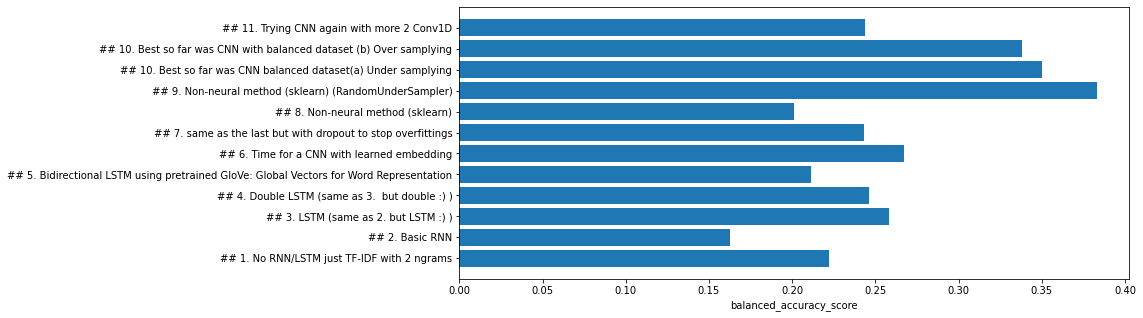

In [ ]:
y_pos = np.arange(len(results_df))
plt.figure(figsize=(12, 5))
plt.barh(y=results_df.models, width=results_df.balanced_accuracy_score);
plt.xlabel('balanced_accuracy_score')
plt.show()

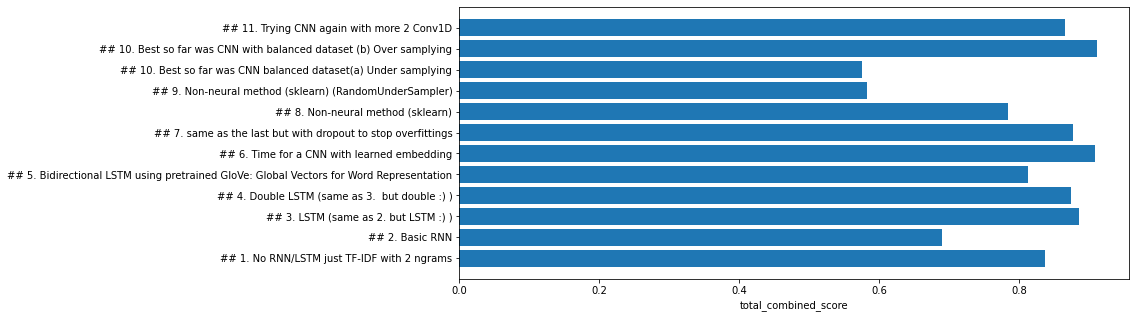

In [ ]:
y_pos = np.arange(len(results_df))
plt.figure(figsize=(12, 5))
plt.barh(y=results_df.models, width=results_df.total_combined_score);
plt.xlabel('total_combined_score')
plt.show()

## 11. Trying CNN again with more 2 Conv1D and oversampling on the training

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_11 (Text  (None, 200)              0         
 Vectorization)                                                  
                                                                 
 embedding_6 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 conv1d_14 (Conv1D)          (None, 196, 128)          64128     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 98, 128)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 98, 128)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 96, 64)          

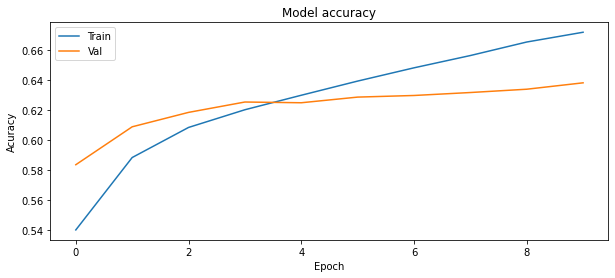

782/782 [==============================] - 4s 4ms/step
[[   0    0    0    0    0    7    1   27    0  154]
 [   0    0    0    0    0    3   14   95    0   88]
 [   0    0    2    0    0   51   14  101    0  649]
 [   0    0    0    0    0    0    4  204    0   16]
 [   0    0    0    0    0   12   25  226    0  461]
 [   0    0    1    0    0  745    8  191    0  386]
 [   0    0    0    0    0    4  850  315    0  744]
 [   0    0    1    0    0  163  122 5728    0 2616]
 [   0    0    0    0    0    6    6  145    0  120]
 [   0    0    0    0    0  248  321 1911    0 8235]]
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00       189
  Electronic       0.00      0.00      0.00       200
        Folk       0.50      0.00      0.00       817
     Hip-Hop       0.00      0.00      0.00       224
       Indie       0.00      0.00      0.00       724
        Jazz       0.60      0.56      0.58      1331
       Metal       0.62      0.44  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


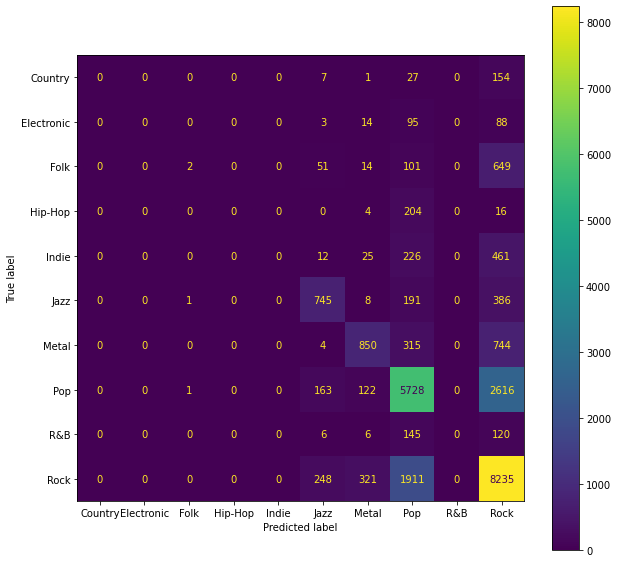

In [ ]:
with open(os.path.join(WORKDIR, 'training_validation_set.pickle'), 'rb') as f:
    train_lyrics, train_genres, val_lyrics, val_genres = pickle.load(f)

from imblearn.over_sampling import RandomOverSampler
rus = RandomOverSampler(random_state=42)
print("Before resampling:", train_lyrics.shape, train_genres.shape, np.unique(train_genres, return_counts=True))
X_res, y_res = rus.fit_resample(np.expand_dims(train_lyrics, axis=1), np.expand_dims(train_genres, axis=1))
train_lyrics = np.squeeze(X_res)
train_genres = np.squeeze(y_res)
print("After resampling:", train_lyrics.shape, train_genres.shape, np.unique(train_genres, return_counts=True))

save_name = "train_model_embedding_with_cnn_2Conv1D"
with open(os.path.join(WORKDIR, 'all_vocab.pickle'), 'rb') as f:
    all_vocab = pickle.load(f)
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH,
    vocabulary=all_vocab)

embedding_size=100 
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(VOCAB_SIZE,
                    embedding_size,
                    input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()
history = model.fit(x=train_lyrics,
                    y=train_genres,
                    validation_data=(val_lyrics, val_genres), 
                    batch_size=128,
                    epochs=10,
                    shuffle=True,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(os.path.join(
                        WORKDIR, save_name),
                        verbose=1,
                        save_best_only=True),
                        tf.keras.callbacks.EarlyStopping(
                            patience=5, verbose=1),
                        tf.keras.callbacks.CSVLogger(os.path.join(
                            WORKDIR, save_name + 'model.csv'), append=True)])
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
  
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
model = tf.keras.models.load_model(os.path.join(WORKDIR, save_name))
test_lyrics, test_genres = give_me_the_test_set()
model.evaluate(x=test_lyrics,
                y=test_genres,
                batch_size=128,
                verbose=1)
predictions = model.predict(x=test_lyrics, verbose=1)
test_preds = np.argmax(predictions, axis=1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_genres, test_preds))
from sklearn.metrics import classification_report
with open(os.path.join(WORKDIR, 'categories.pickle'), 'rb') as f:
    categories = pickle.load(f)
print(classification_report(test_genres, test_preds, target_names=categories))
from sklearn.metrics import accuracy_score
print("accuracy_score", accuracy_score(test_genres, test_preds))
from sklearn.metrics import balanced_accuracy_score
print("balanced_accuracy_score", balanced_accuracy_score(test_genres, test_preds))
#random performance would score 0, while keeping perfect performance at a score of 1
print("balanced_accuracy_score (adjusted)", balanced_accuracy_score(test_genres, test_preds, adjusted=True))
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state(test_genres, predictions)
print("SparseCategoricalAccuracy", m.result().numpy())
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_genres, test_preds, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

# Analysis of the test set used for model comparison

In [ ]:
test_lyrics, test_genres = give_me_the_test_set()

In [ ]:
print(pd.Series(test_lyrics).str.split(" ").apply(len).describe())

count    25020.000000
mean       211.106595
std        128.026429
min          1.000000
25%        127.000000
50%        181.000000
75%        256.000000
max       1819.000000
dtype: float64


In [ ]:
pd.Series(test_lyrics)[pd.Series(test_lyrics).str.split(" ").apply(lambda x : len(x) < 32)].to_frame()

0
80     To hope until hope creates\nFrom its own wreck...
156    and so\nmy friends\nwe'll say goodnight\nfor t...
328    Falstaff\nThe thirst slaker\nFalstaff\nThe thi...
507    You're in my dreams now\nWelcome\nWelcome\nHey...
718    stop Radioactivity\nIs in the air for you and ...
...                                                  ...
24262  You stay with David\nI'll stay with Jude\nYou ...
24494                                    check this out.
24663  Oh yeah, all right\nAre you going to be in my ...
24685  Paint!\n\nPaint!\n\nCollide a clause, unremitt...
24912  The Beatsie Boys They Are They're Comin' Home\...

[201 rows x 1 columns]